# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [7]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [8]:
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # sklearn 내 confusion matrix 계산 함수
import matplotlib.pyplot as plt # 시각화를 위한 라이브러리
import torchvision.transforms as T # 이미지 변환을 위한 모듈

In [9]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

# 이미지 탐색

In [10]:
import pandas as pd

# CSV 파일 로드
train = pd.read_csv('/data/ephemeral/home/datasets_fin/train.csv')
meta = pd.read_csv('/data/ephemeral/home/datasets_fin/meta.csv')

train_meta = pd.merge(train, meta, on='target', how='inner')
train_meta



,ID,target,class_name
0,002f99746285dfdd.jpg,16,vehicle_registration_plate
1,00b2f44967580c74.jpg,16,vehicle_registration_plate
2,00f59b12e9e08f29.jpg,16,vehicle_registration_plate
3,04d106668176a2e6.jpg,16,vehicle_registration_plate
4,05c521f2659c0711.jpg,16,vehicle_registration_plate
...,...,...,...
1565,efb9805cc6106c48.jpg,6,medical_bill_receipts
1566,f230a7ad534c49a6.jpg,6,medical_bill_receipts
1567,fa6d6811b624d725.jpg,6,medical_bill_receipts
1568,fc86eb71611c9854.jpg,6,medical_bill_receipts


In [39]:
# 이미지 파일 리스트
# target이 0인 ID 추출
target_zero_ids = train_meta[train_meta['target'] == 2]['ID'].tolist()

# 디렉토리 설정
dataset_dir = '/data/ephemeral/home/datasets_fin/train/'

# .jpg 파일만 리스트에 포함, target이 0인 ID에 해당하는 파일만 포함
img_file_list = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg') and f.split(',')[0] in target_zero_ids]

# 파일 리스트 정렬
img_file_list.sort()

len(img_file_list)

100

In [ ]:
# 이미지 시각화
plt.figure(figsize=(16,10))
#img_file_list = img_file_list[:15]  # 리스트를 15개로 제한

# 전체 이미지 개수에 따라 subplot의 크기 조정
rows = len(img_file_list) // 3 + (len(img_file_list) % 3 > 0)  # 3열 기준으로 행 계산
cols = 3  # 항상 3열로 표시

# figsize 조정: 각 이미지에 충분한 공간을 할당
plt.figure(figsize=(cols * 5, rows * 5))  # 각 이미지당 가로 5인치, 세로 5인치 할당

for i, f in enumerate(img_file_list):
    plt.subplot(rows, cols, i + 1)  # rows x cols 그리드에서 i+1 번째 위치에 subplot 생성
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = Image.open(os.path.join(dataset_dir, f))  # 파일 경로 결합 오류 수정
    plt.imshow(img)

plt.tight_layout()  # subplot 간의 여백을 자동으로 조정
plt.show()

In [123]:
from PIL import Image
import os

image_sizes = []

# 이미지 파일이 저장된 디렉토리
image_dir = '/data/ephemeral/home/datasets_fin/train'

# 이미지 크기 수집
for filename in os.listdir(image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일 형식 확인
        img_path = os.path.join(image_dir, filename)
        with Image.open(img_path) as img:
            width, height = img.size
            image_sizes.append((width, height))


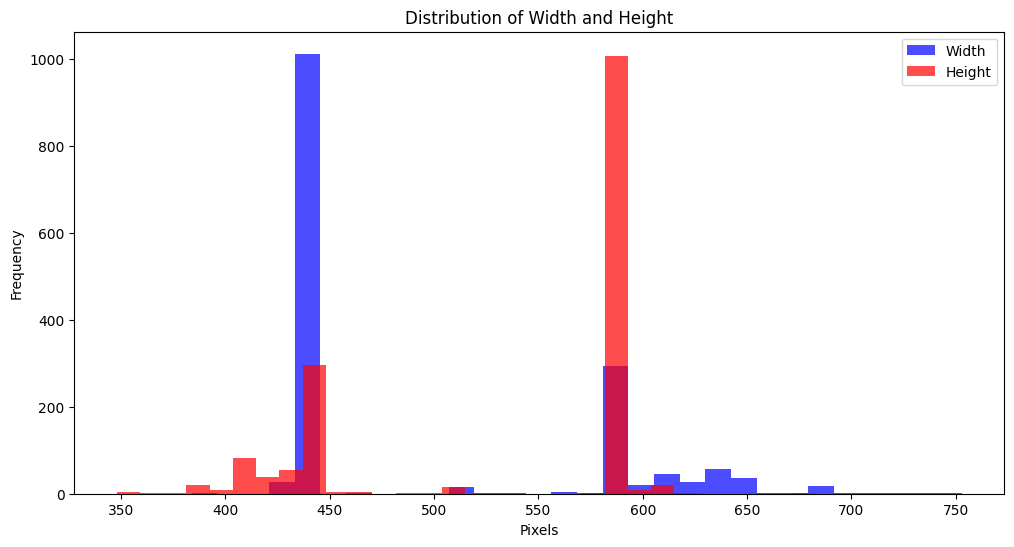

In [124]:
import matplotlib.pyplot as plt

# width와 height를 분리
widths, heights = zip(*image_sizes)

# Width 분포 시각화
plt.figure(figsize=(12, 6))
plt.hist(widths, bins=30, alpha=0.7, color='blue', label='Width')
plt.hist(heights, bins=30, alpha=0.7, color='red', label='Height')
plt.title('Distribution of Width and Height')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.show()


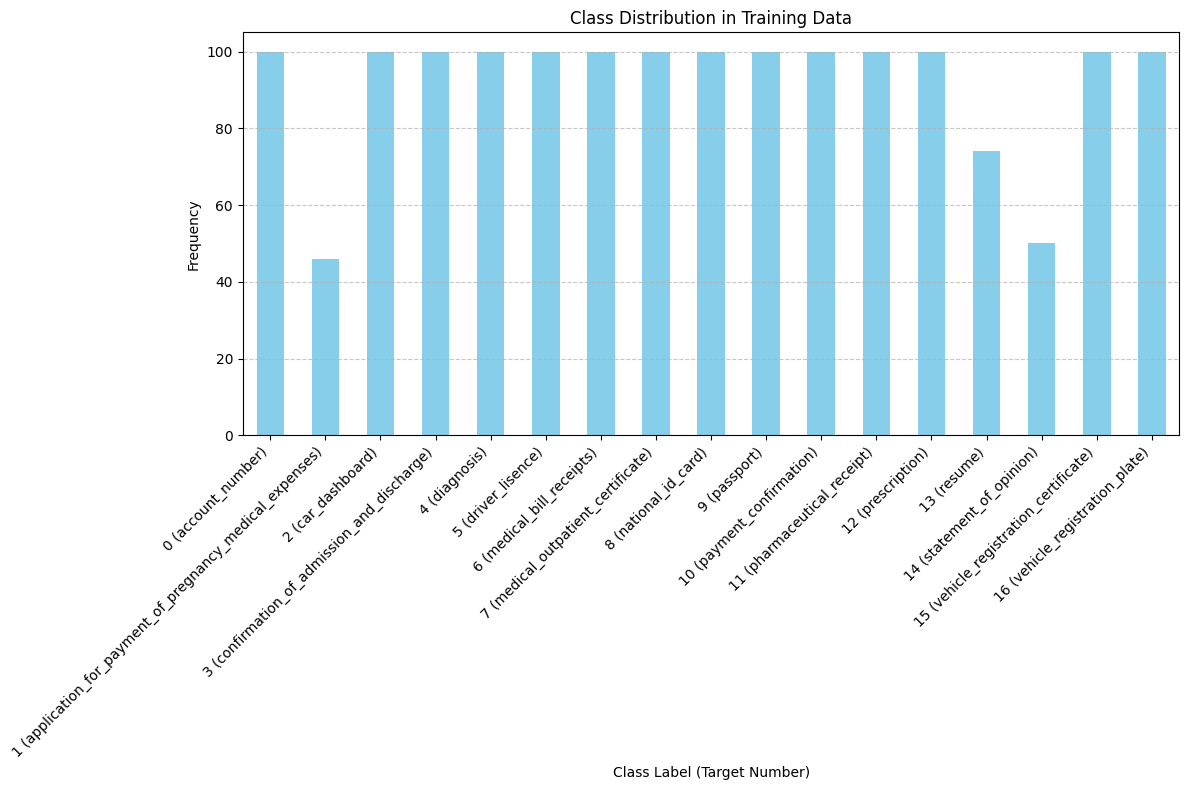

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 로드
data_path = '/data/ephemeral/home/datasets_fin/train.csv'  # 실제 파일 경로로 대체
data = pd.read_csv(data_path)

meta_path = '/data/ephemeral/home/datasets_fin/meta.csv'  # 실제 파일 경로로 대체
meta = pd.read_csv(meta_path)

# 'meta' 데이터프레임에서 'target'과 'class_name' 컬럼만 선택
meta = meta[['target', 'class_name']]

# 'data'와 'meta' 데이터프레임 병합
data = pd.merge(data, meta, on='target', how='inner')

# 'target' 컬럼의 값에 대한 빈도수 계산
class_counts = data['target'].value_counts().sort_index()

# 클래스 이름 매핑
class_labels = meta.set_index('target')['class_name']

# 클래스 이름과 타겟 번호를 함께 레이블로 표시
class_counts.index = class_counts.index.map(lambda x: f"{x} ({class_labels[x]})")

# 막대 그래프로 시각화
plt.figure(figsize=(12, 8))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Label (Target Number)')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # 클래스 레이블을 기울여서 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # 레이아웃 조정
plt.show()
